In [3]:
# model implementation
from ml.models.linear import LogisticRegression
from ml.algorithms.optimization import GradientDescent
# from ml.models.statistical import GaussianDiscriminantAnalysis

# model selection
from ml.model_selection import GridSearchCV
from ml.functions.metrics.classification import F1Score, BinaryAccuracy
from ml.stats import ClassificationStats

# data manipulation
from ml.dataset import load_csv, split_train_test
from ml.algorithms.normalization import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
from ml.models.base import AbstractModel

np.random.seed(25)

## Q1

In [4]:
X, y = load_csv('./datasets/breastcancer.csv')

# y = y.astype(int)
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8, shuffle=True)

# y_train = y_train.ravel()
# y_test = y_test.ravel()

In [5]:
class GaussianDiscriminantAnalysis(AbstractModel):

    def __init__(self):
        params = None
        super(GaussianDiscriminantAnalysis, self).__init__(params)

    def compute_classes_probabilities(self, outputs):
        _, count_class_k = np.unique(outputs, return_counts=True)
        return count_class_k / outputs.shape[0]

    def compute_cov_matrices(self, inputs, outputs):
        
        
        class0_x = inputs[outputs == 0.]
        cov_matrices = np.array([np.cov(class0_x, rowvar=False)])
        for class_k in range(1, np.max(outputs) + 1):
            covariance_matrix = np.cov(inputs[outputs == class_k,:], rowvar=False)
            cov_matrices = np.concatenate([cov_matrices, [covariance_matrix]])

        return cov_matrices

    def compute_means(self, inputs, outputs):
        means = np.array(np.mean(inputs[outputs == 0], axis=0, keepdims=True))
        for class_k in range(1, np.max(outputs) + 1):
            mean_k = np.mean(inputs[outputs == class_k], axis=0, keepdims=True)
            means = np.concatenate([means, mean_k])

        return means


    def fit(self, inputs, outputs):
        self.num_classes = len(np.unique(outputs))
        self.prob_classes = self.compute_classes_probabilities(outputs)
        self.cov_matrices = self.compute_cov_matrices(inputs, outputs)
        self.means = self.compute_means(inputs, outputs)

        self.trained = True

    def predict(self, x):
        y_pred = []

        for i in range(x.shape[0]):
            probs = []

            for k in range(self.num_classes):
                p0 = np.log(self.prob_classes[k])

                p1 = -0.5 * np.log(np.linalg.det(self.cov_matrices[k]))

                distance_from_mean = x[i] - self.means[k]
                p2 = -(0.5) * (distance_from_mean @ (np.linalg.pinv(self.cov_matrices[k]) @ distance_from_mean.T))

                probs.append(p0+p1+p2)

            y_pred.append(np.argmax(probs))

        return np.array(y_pred)


grid_classifiers = GridSearchCV(stats_generator=ClassificationStats)

grid_classifiers.add(LogisticRegression, {
    "solver": GradientDescent(epochs=4000, learning_rate=0.1, regularization=0.001, metrics=BinaryAccuracy()),
    "dataScaler": MinMaxScaler})

grid_classifiers.add(GaussianDiscriminantAnalysis, {})

best_classifier = grid_classifiers.search(X_train, y_train, num_folds=10, score=BinaryAccuracy(), score_minimize=False, shuffle=False)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 30 but corresponding boolean dimension is 1

## Q1.a
### Finding best Logistic Regression - Gradient Descent and grid search with k-fold cross-validation

In [4]:
grid = GridSearchCV(stats_generator=ClassificationStats)

i=0
for regularization_term in [0.01, 0.001]:
    for learning_rate in [0.1, 0.01]:
        grid.add(LogisticRegression, {
            "solver": GradientDescent(epochs=4000, learning_rate=learning_rate, regularization=regularization_term, metrics=F1Score()),
            "dataScaler": MinMaxScaler})
        
        print(f"Grid search candidate {i}: Logistic regression, learning rate={learning_rate}, regularization={regularization_term}, score=F1-score")
        i+=1

best = grid.search(X_train, y_train, num_folds=10, score=F1Score(), score_minimize=False, shuffle=True)

Grid search candidate 0: Logistic regression, learning rate=0.1, regularization=0.01, score=F1-score
Grid search candidate 1: Logistic regression, learning rate=0.01, regularization=0.01, score=F1-score
Grid search candidate 2: Logistic regression, learning rate=0.1, regularization=0.001, score=F1-score
Grid search candidate 3: Logistic regression, learning rate=0.01, regularization=0.001, score=F1-score


Best candidate: 2 - Learning rate: 0.1 - Regularization term: 0.001


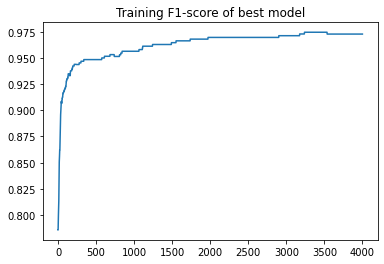

In [5]:
# Best model information
solver = grid.best_model_params['solver']
print("Best candidate:", grid.index_of_best, "- Learning rate:", solver.learning_rate, "- Regularization term:", solver.regularization)

model = grid.best_model(**grid.best_model_params)
training_score = model.fit(X_train, y_train)

plt.plot(training_score)
plt.title("Training F1-score of best model")
plt.show()

### Compare models - grid search with k-fold cross-validation

In [3]:
grid_classifiers = GridSearchCV(stats_generator=ClassificationStats)

grid_classifiers.add(LogisticRegression, {
    "solver": GradientDescent(epochs=4000, learning_rate=0.1, regularization=0.001, metrics=BinaryAccuracy()),
    "dataScaler": MinMaxScaler})

grid_classifiers.add(GaussianDiscriminantAnalysis, {})

best_classifier = grid_classifiers.search(X_train, y_train, num_folds=10, score=BinaryAccuracy(), score_minimize=False, shuffle=False)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [6]:
gda = GaussianDiscriminantAnalysis()
gda.fit(X, y)


print(F1Score().measure(y_test, gda.predict(X_test)))
BinaryAccuracy().measure(y_test, gda.predict(X_test))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

## Q1.b
### Logistic regression

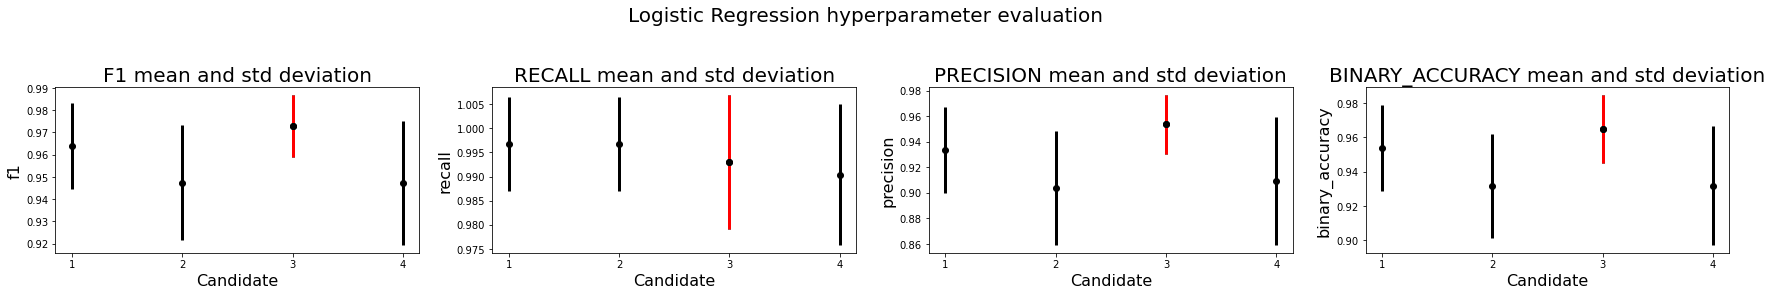

In [7]:
num_candidates = len(grid.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("Logistic Regression hyperparameter evaluation", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    for i in range(num_candidates):
        means.append(np.mean(grid.stats[i].stats["values"][metric]))
        std.append(np.std(grid.stats[i].stats["values"][metric]))
    plt.subplot(1, 4, k+1)
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    plt.errorbar(grid.index_of_best, means[grid.index_of_best], std[grid.index_of_best], ecolor='red', fmt='ok', lw=3)
    plt.xticks(np.arange(num_candidates), labels=np.arange(num_candidates)+1)
    plt.xlabel("Candidate", fontsize=16)
    plt.ylabel(metric, fontsize=16)
    k+=1

## Classifiers analysis

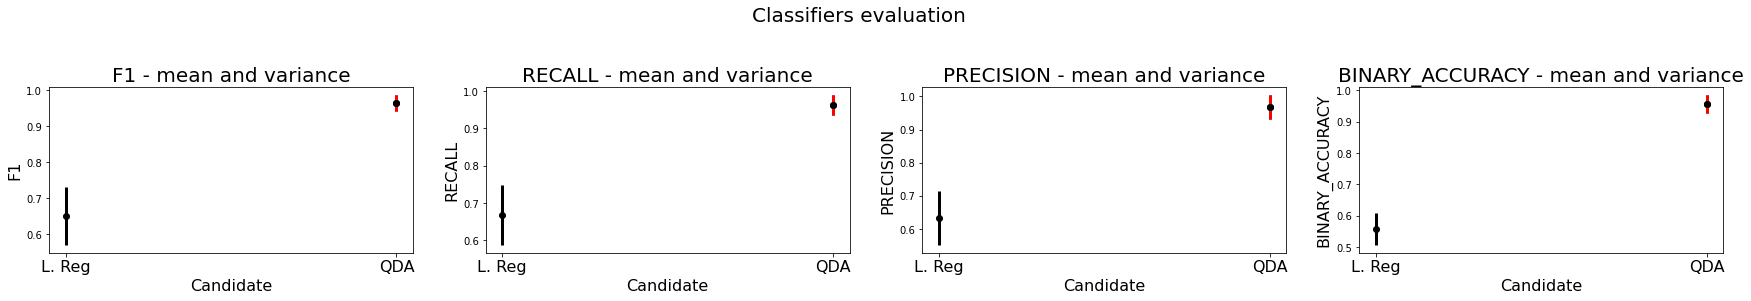

In [ ]:
num_candidates = len(grid_classifiers.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("Classifiers evaluation", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    for i in range(num_candidates):
        means.append(np.mean(grid_classifiers.stats[i].stats["values"][metric]))
        std.append(np.std(grid_classifiers.stats[i].stats["values"][metric]))
    plt.subplot(1, 4, k+1)
    plt.title(metric.upper()+" - mean and variance", fontsize=20)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    plt.errorbar(grid_classifiers.index_of_best, means[grid_classifiers.index_of_best], std[grid_classifiers.index_of_best], ecolor='red', fmt='ok', lw=3)
    plt.xticks(np.arange(num_candidates), labels=['L. Reg', 'QDA'], fontsize=16)
    plt.xlabel("Candidate", fontsize=16)
    plt.ylabel(metric.upper(), fontsize=16)
    k+=1